## Загрузим необоходимые библиотеки

In [95]:
from imutils.video import VideoStream
from imutils.video import FPS
import numpy as np
import argparse
import imutils
import time
import cv2
import matplotlib.pyplot as plt 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

Установим классы 

In [74]:
CLASSES = ["nobody", "person1", "person2", "person3", "person4", "person5", "person6", "person7", "person8", "person9", "visitor_old", "visitor_yng" , "background"]
COLORS = np.random.uniform(0, 255, size=(len(CLASSES), 3))

Загрузим первый ролик

In [ ]:
vs = cv2.VideoCapture("/content/train1.avi")

Вырежим один кадр и посмотрим на него

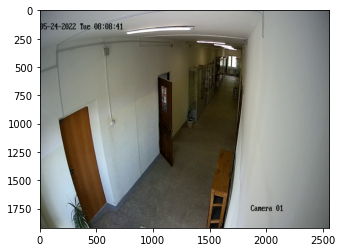

In [ ]:
ret, frame = vs.read()

plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
plt.show()

Загрузим исходники нейросети. В примере рассматривается MobileNet

In [ ]:
# https://github.com/PINTO0309/MobileNet-SSD-RealSense

In [ ]:
config_file = '/content/MobileNetSSD_deploy.prototxt'
model_file = '/content/MobileNetSSD_deploy.caffemodel'

net = cv2.dnn.readNet(model=config_file, config=model_file, framework='Caffe')

Классификация

KeyboardInterrupt: ignored

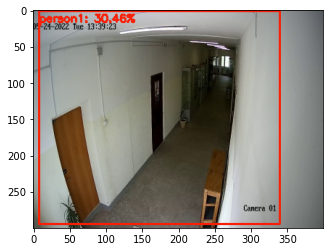

In [113]:
confidence_avr = 0.2 # порог классификации
second = 0 # будем считывать каждую секунду а не каждый кадр
pred = np.array([])

while True:
  vs.set(cv2.CAP_PROP_POS_MSEC,second*1000)
  second += 1

  ret, frame = vs.read()
  frame = imutils.resize(frame, width=400)

  (h, w) = frame.shape[:2]

  blob = cv2.dnn.blobFromImage(cv2.resize(frame, (300, 300)),
		0.007843, (300, 300), 127.5)

  net.setInput(blob)
  detections = net.forward()

  
  for i in np.arange(0, detections.shape[2]):
	  confidence = detections[0, 0, i, 2]

	  if confidence > confidence_avr:

		  idx = int(detections[0, 0, i, 1])
		  box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
		  (startX, startY, endX, endY) = box.astype("int")

		  if idx <= 11:
		  	pred = np.append(pred,idx)

		  	label = "{}: {:.2f}%".format(CLASSES[idx], confidence * 100)
		  	cv2.rectangle(frame, (startX, startY), (endX, endY), COLORS[idx], 2)
		  	y = startY - 15 if startY - 15 > 15 else startY + 15
		  	cv2.putText(frame, label, (startX, y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, COLORS[idx], 2)
				
		  	plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
		  	#plt.show()
				

## Посмотрим на ответ и загрузим датасет 

In [93]:
pred

array([1., 1., 1., 1., 9., 9., 9., 9., 9., 9., 9.])

In [96]:
df_train = pd.read_csv("/content/train.csv")

## Рассмотрим датасет по ближе

In [98]:
df_train.head(3)

,id,date,employee,action
0,1256,2022-05-24 08:08:36,2,15.0
1,1257,2022-05-24 08:08:37,2,4.0
2,1258,2022-05-24 08:12:13,3,15.0


In [99]:
df_train.shape

(3519, 4)

In [100]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3519 entries, 0 to 3518
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        3519 non-null   int64  
 1   date      3519 non-null   object 
 2   employee  3519 non-null   int64  
 3   action    3519 non-null   float64
dtypes: float64(1), int64(2), object(1)
memory usage: 110.1+ KB


Пострим на распределение данных

Text(0.5, 1.0, 'Распределение посетителей и работников')

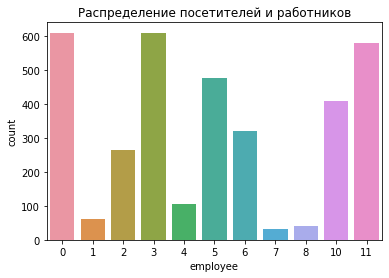

In [104]:
sns.countplot(x = "employee" , data  = df_train).set_title('Распределение посетителей и работников')

## Узнаем точность модели

In [116]:
y_train = df_train[:len(pred)].employee

In [117]:
from sklearn.metrics import recall_score

recall_score(y_train, pred, average='macro', zero_division = 0)

0.06790123456790124